In [1]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144792 sha256=6aed1bbfd35da7a418a2c679dba86a22a639950a517263eb52fe2a98d33e72a0
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [2]:
import numpy as np
import pandas as pd
from pandas.io.parsers import StringIO
from io import StringIO

import Levenshtein as Leven

from datetime import date
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
#подгружаем грязные данные
data = pd.read_csv("Data.csv", sep=',')

In [4]:
#удаляем неразделяемые строчки (85)
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data = data[data['failed'] == False]

#удаляем наблюдения до 2001 года (ошибки, например, дата заполнения вместо даты рождения)
data['index'] = range(1, len(data) + 1)
data = data[['index', 'dept_code', 'issue_date', 'issuer_eng' ]]
data.groupby(['dept_code', 'issuer_eng']).agg(['count']).groupby(['dept_code']).agg(['count'])
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']

In [5]:
# Заменяем дату на количество дней от минимальной в датасете
data['issue_date']= pd.to_datetime(data['issue_date'])
fromDate = min(data['issue_date'])
data['timedelta'] = (data['issue_date'] - fromDate).dt.days.astype(int)
print(data[['issue_date', 'timedelta']].head())
data.drop('issue_date', axis = 1, inplace = True)

  issue_date  timedelta
0 2001-11-05        305
1 2002-03-22        442
2 2002-05-18        499
3 2002-08-13        586
4 2003-07-17        924


In [6]:
#Делим на тестовую и обучающую
x_data = data[['dept_code', 'timedelta']]
y_data = data[['issuer_eng']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [7]:
#Смотрим на точность классификатора с рандомным количеством соседей
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(x_train, y_train)
y_test['knn_predict'] = neigh.predict(x_test)
neigh.score(x_test, y_test['issuer_eng'])

0.6779538904899135

In [ ]:
#Определеям оптимальное количество соседей
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)
knn_gscv.best_params_

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [8]:
#Точность моделей с оптимальным количеством соседей
neigh_10 = KNeighborsClassifier(n_neighbors = 10)
neigh_10.fit(x_train, y_train)
y_test['knn_predict_10'] = neigh_10.predict(x_test)
neigh_10.score(x_test, y_test['issuer_eng'])

0.716954851104707

In [9]:
#Рассчитываем расстояние Левенштейна между реальными и предсказанными значениями
y_test['levenshtein'] = 0
for ind in y_test.index: 
     y_test['levenshtein'][ind] = Leven.distance(y_test['issuer_eng'][ind], y_test['knn_predict_10'][ind])

In [ ]:
y_test = pd.read_csv("test_knn_dirty.csv")

In [10]:
print(y_test["levenshtein"].mean(),y_test["levenshtein"].median())

2.056147934678194 0.0


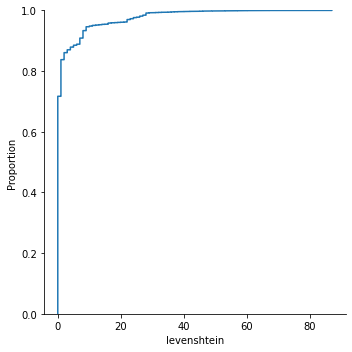

In [ ]:
#График распределения расстояния Левенштейна с накоплением
sns.displot(y_test, x="levenshtein", kind="ecdf")

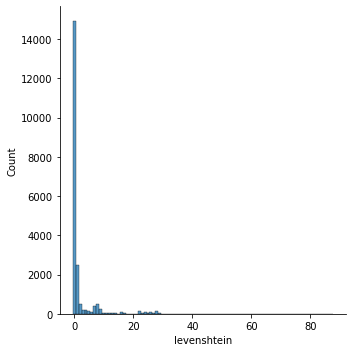

In [ ]:
#Гистограмма распределения расстояния Левенштейна
g = sns.displot(y_test, x="levenshtein", discrete=True)


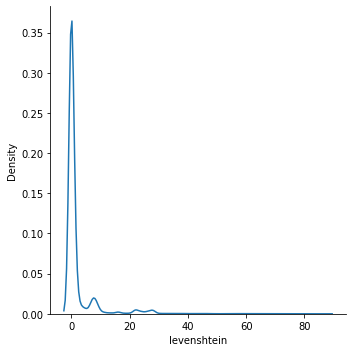

In [ ]:
#График плотности распределения расстояния Левенштейна
g = sns.displot(y_test, x="levenshtein", kind = 'kde')